# Running an experiment

In this tutorial, you learn how to perform an experiment and then access the recorded data to analyse it. 

## Running the experiment

You can look at an experiment as a machine that produces data from a configuration, which defines the simulation we want to perform, how many runs of it, which data to collect, and where to save it.

The experiment can be configured through the API or from YAML. 

Let's go for YAML: we configure an experiment where 10 agents perform about 3 hours of navigation in the [Cross scenario](../reference/sim/python/scenarios/cross.html).

In [1]:
from navground import sim

yaml = """
steps: 100000
time_step: 0.1
record_safety_violation: true
record_task_events: true
record_pose: true
runs: 2
save_directory: .
scenario:
  type: Cross
  radius: 5
  side: 5
  agent_margin: 0.3
  add_safety_to_agent_margin: true
  tolerance: 0.2
  position_noise: 0.2
  groups:
    - number: 10
      control_period: 0.1
      behavior:
        type: ORCA
        safety_margin: 0.25
      radius: 0.1
      kinematics:
        type: Omni
        max_speed: 1.0
        max_angular_speed: 3.0
      state_estimation:
        type: Bounded
        range_of_view: 2.0
"""

experiment = sim.load_experiment(yaml)

We have specified to save the data in the current directory by adding
`save_directory: .`; leaving this line out, would avoid that the experiment saves data to HDF5.

Running the experiment using the Python API

In [2]:
experiment.run()

is equivalent to execute 
```
run_py <yaml_file>
```
from the command line.

The experiment takes some time to execute

In [3]:
experiment.duration

datetime.timedelta(seconds=1, microseconds=288567)

and saves the results to an H5DF file

In [4]:
experiment.path

PosixPath('experiment_2023-07-04_16-55-12/data.h5')

## Experimental data analysis

We can load the HDF5 file using ``h5py``. 
In case you need, install it with 
```
pip install h5py
```

In [5]:
import h5py

data = h5py.File(experiment.path)

The file stores some metadata about the experiment

In [6]:
data.attrs.keys()

<KeysViewHDF5 ['begin_time', 'duration_ns', 'experiment']>

like the duration: let's check that it reports the same duration as above 

In [7]:
data.attrs.get('duration_ns') / 1e9

1.288567292

The metadata contains the YAML dump of the experiment itself. This way, users can reload and potentially rerun the same experiment.

In [8]:
recorded_yaml = data.attrs.get('experiment')
recorded_experiment = sim.load_experiment(recorded_yaml)

Each run is recorded in a separate HDF5 group. Let's list them

In [9]:
data.keys()

<KeysViewHDF5 ['run_0', 'run_1']>

and load the first one

In [10]:
run = data['run_0']

Runs contains some metadata too

In [11]:
run.attrs.keys()

<KeysViewHDF5 ['duration_ns', 'seed', 'steps', 'time_step', 'world']>

The duration of a run includes only the time required to perform the simulation, not initializing it or saving the data.

In [12]:
run.attrs.get('duration_ns') / 1e9

0.635798875

Other attributes includes the seed

In [13]:
run.attrs['seed']

0

and the number of steps performed

In [14]:
run.attrs['steps']

100000

The run also saves a YAML dump of the world at the begin of the simulation, which we can load

In [15]:
wold_yaml = run.attrs.get('world')
world = sim.load_world(wold_yaml)

and display

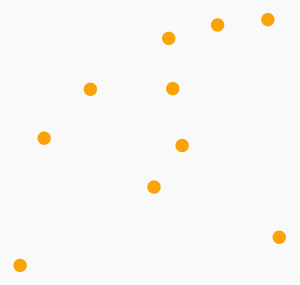

In [16]:
from IPython.display import SVG
import numpy as np
from matplotlib import pyplot as plt
from navground.sim.ui import to_svg

wold_yaml = run.attrs.get('world')
world = sim.load_world(wold_yaml)
SVG(to_svg.svg_for_world(world, width=300))

The actual data collected during the run is saved in H5DF datasets

In [17]:
run.keys()

<KeysViewHDF5 ['poses', 'safety_violations', 'task_events']>

Let's plot the trajectories off all agents: first agent in blue, others in gray.

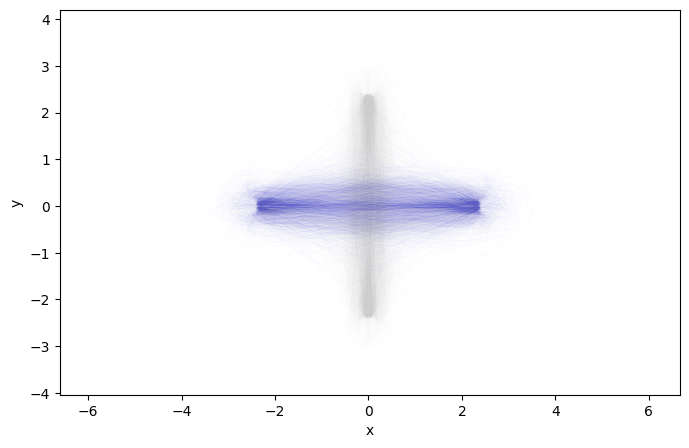

In [18]:
plt.figure(figsize=(8, 5))

ps = run['poses']

for n in range(ps.shape[1]):
    color = 'k' if n else 'b'
    alpha = 0.05 if n else 0.5
    plt.plot(ps[:, n, 0], ps[:, n, 1], '-', color=color, alpha=alpha, linewidth=0.01)

plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal');

They were indeed doing a crossing pattern.

Let's plot how much the safety margin was violed.

In [19]:
svs = np.concatenate(run['safety_violations'])

In [20]:
f = np.count_nonzero(svs) / len(svs)
print(f'Safety margin was violated {f:.1%} of the time')

Safety margin was violated 10.0% of the time


Most violation should be small. Let's check this by plotting their distribution.

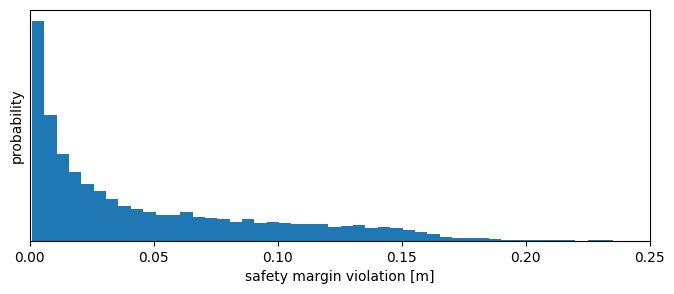

In [21]:
plt.figure(figsize=(8, 3))
plt.hist(svs, density=True, bins=np.linspace(1e-3, 0.25, 51))
plt.xlabel('safety margin violation [m]')
plt.ylabel('probability')
plt.xlim(0, 0.25)
plt.tick_params(left = False, labelleft = False);

In [22]:
np.quantile(svs, 0.999)

0.17244763869047244

We have also stored logs from the event tasks.

In [23]:
ts = data['run_0']['task_events']

In [24]:
ts.keys()

<KeysViewHDF5 ['agent_0', 'agent_1', 'agent_2', 'agent_3', 'agent_4', 'agent_5', 'agent_6', 'agent_7', 'agent_8', 'agent_9']>

For each agents, where [WaypointsTask](../reference/sim/python/tasks/waypoints.html#navground.sim.tasks.WaypointsTask.log_size) tells us when it started moving towards which waypoint as a list ``[time, target_x, target_y, target_theta]``.

In [25]:
task_events, *_ = ts.values()
# time, x, y, theta
np.asarray(task_events[:2]).tolist()

[[0.0, 1.0, 2.5, 0.0], [5.099997520446777, 1.0, -2.5, -0.0]]

We collect the duration it took to reach a new waypoint, ignoring the first when agents started from radom positions.  

In [26]:
dts = []

for task in ts.values():
    for (start, *_), (end, *_) in zip(task[1:], task[2:]):
        duration = end - start
        dts.append(duration)

print(f'The time to reach a waypoint ranges betweeen {min(dts):.2f} and {max(dts):.2f} seconds,\n'
      '99% of the time lying between '
      f'{np.quantile(dts, 0.005):.2f} and {np.quantile(dts, 0.995):.2f} seconds') 

The time to reach a waypoint ranges betweeen 4.88 and 32.53 seconds,
99% of the time lying between 4.90 and 16.52 seconds


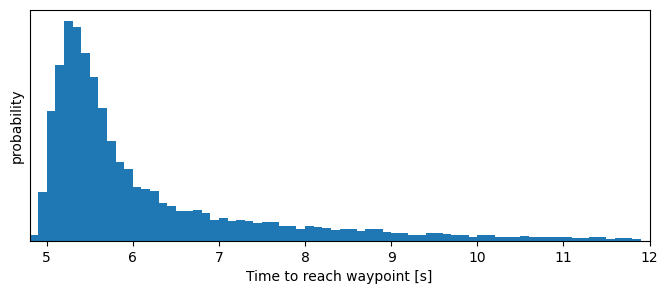

In [27]:
plt.figure(figsize=(8, 3))
plt.hist(dts, density=True, bins=np.arange(4.8, 12, 0.1))
plt.xlabel('Time to reach waypoint [s]')
plt.xlim(4.8, 12)
plt.ylabel('probability')
plt.tick_params(left = False, labelleft = False);